In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960 
DATASET_MAPPING = 'jane-street-market-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F23304%2F1691737%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20201203%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20201203T010917Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4fd1bc7a9656f5063ac64d49263f741df6d929ca7a4c3ef958a57321318456b080c5f816602ca2ed7283553e1e2ea7d838f65abc6951d512b9edc7d5959622c2b605518781bae36aed13d8b545fd69e08bcde98cbfa2b2c4f8f0b46fdc784e367ad3f92dc155cc83d225761795c3b55af34ad1a8014a392cb1c71c96f59889bc244734709cb1b453f946d1cb147068bd23adb45057f153df305047a5f70d7573817bdfc17ff4fd637a92d287beae1ef6cc76b5f27be82c73ef6a5c772cfd3310b6a63d282e6e63c0ac2c794696979429e18dd65369920a9eb23332014beac41912362d8efdd1103549f3f91040ab9ed5e57d6b99d85ee1dd0a656bfb31f682cf'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

os.makedirs(KAGGLE_INPUT_PATH, 777)
os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


FileExistsError: [Errno 17] File exists: '/home/kaggle/input'

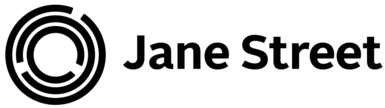

# Jane Street Market Prediction: A simple EDA

> "*Machine learning (ML) at Jane Street begins, unsurprisingly, with data. We collect and store around 2.3TB of market data every day. Hidden in those petabytes of data are the relationships and statistical regularities which inform the models inside our strategies. But it’s not just awesome models. ML work in a production environment like Jane Street’s involves many interconnected pieces.*" -- [Jane Street Tech Blog "*Real world machine learning*"](https://blog.janestreet.com/real-world-machine-learning-part-1/).

This notebook is a simple exploratory data analysis (EDA) of the files provided for the kaggle [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction) competition. Here we shall...

> "**Explore the data:** *It’s hard to know what techniques to throw at a problem before we understand what the data looks like, and indeed figure out what data to use. Spending the time to visualize and understand the structure of the problem helps pick the right modeling tools for the job. Plus, pretty plots are catnip to traders and researchers!*"

## <center style="background-color:Gainsboro; width:40%;">Contents</center>
* [The train.csv file is big](#train_csv)
* [Cumulative return](#return)
* [Weight](#weight)
* [The features](#features)
* [The `features.csv` file](#features_file)
* [Action](#action)
* [The first day ("day 0")](#day_0)
* [Is there any missing data?](#missing)
* [DABL plots (action and resp)](#DABL)
* [Permutation Importance using the Random Forest](#permutation)
* [Is there any correlation between day 0 and day 1?](#Pearson)
* [The test data](#test_data)
* [Evaluation](#evaluation)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)
!pip install dabl > /dev/null
import dabl
import warnings
warnings.filterwarnings('ignore')
colorMap = sns.light_palette("blue", as_cmap=True)
import missingno as msno
# install datatable
!pip install datatable > /dev/null
import datatable as dt

## <center style="background-color:Gainsboro; width:40%;">The train.csv file is big</center><a class="anchor" id="train_csv"></a>

The train.csv is large: 5.77G. Let us see just how many rows it has:

In [8]:
!wc -l ../input/jane-street-market-prediction/train.csv

2390492 ../input/jane-street-market-prediction/train.csv


We can see that it has a total of 2,390,492 rows. I recommend reading this magnificent [Tutorial on reading large datasets](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets) by [Vopani](https://www.kaggle.com/rohanrao).

I have used pandas to load in the `train.csv` and it took almost 2 minutes. To speed things up here I shall use [datatable](https://datatable.readthedocs.io/en/latest/):

In [9]:
%%time

train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')

CPU times: user 33.3 s, sys: 8.42 s, total: 41.7 s
Wall time: 10.6 s


and then [convert to a pandas dataframe](https://datatable.readthedocs.io/en/latest/api/frame/to_pandas.html)

In [10]:
%%time

train_data = train_data_datatable.to_pandas()

CPU times: user 6.29 s, sys: 8.6 s, total: 14.9 s
Wall time: 10 s


We now have loaded `train.csv` in less than 17 seconds.

## <center style="background-color:Gainsboro; width:40%;">Cumulative return</center><a class="anchor" id="return"></a>
There are a total of 500 days of data in `train.csv` (*i.e.* two years of trading data). Let us take a look at the cumulative return over time

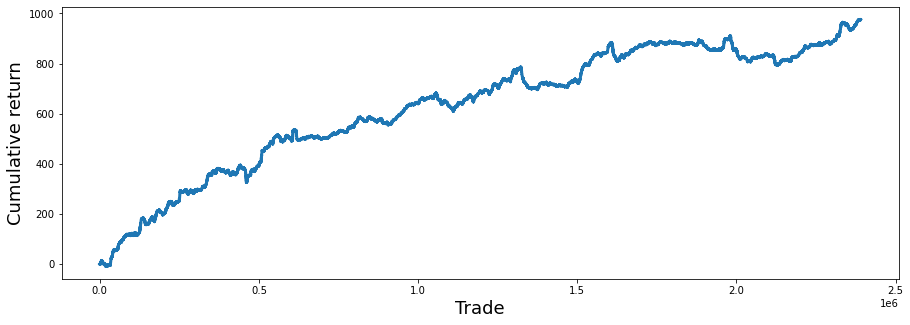

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("Cumulative return", fontsize=18);
balance.plot(lw=3);

as well as four [time horizons](https://www.investopedia.com/terms/t/timehorizon.asp)
> "*The longer the Time Horizon, the more aggressive, or riskier portfolio, an investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.*"

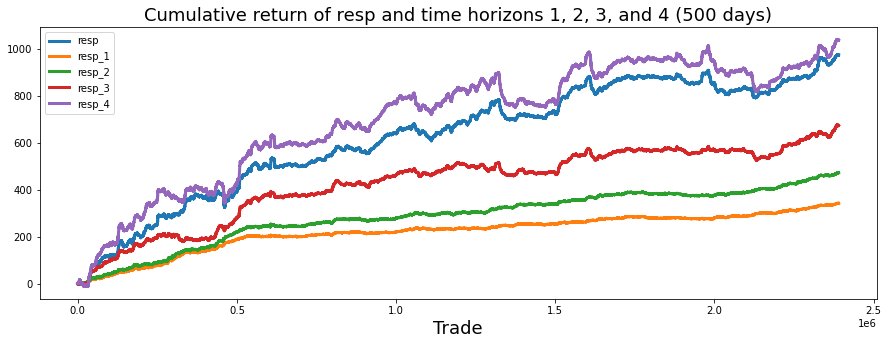

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
resp_1= pd.Series(train_data['resp_1']).cumsum()
resp_2= pd.Series(train_data['resp_2']).cumsum()
resp_3= pd.Series(train_data['resp_3']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return of resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

We can see that `resp` (in blue) most closely follows time horizon 4 (`resp_4` is the uppermost curve, in purple) but is slightly more conservative.

Let us now plot a histogram of all of the `resp` values (here only shown for values between -0.05 and 0.05)

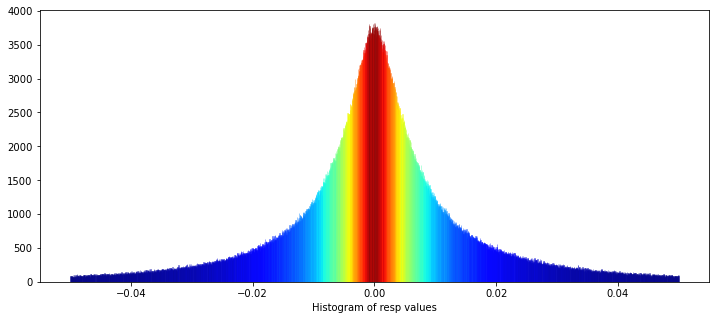

In [13]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['resp'], 
             bins=3000, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             axlabel="Histogram of resp values",
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

This distribution has very long tails

In [14]:
min_resp = train_data['resp'].min()
print('The minimum value for resp is: %.5f' % min_resp)
max_resp = train_data['resp'].max()
print('The maximum value for resp is:  %.5f' % max_resp)

The minimum value for resp is: -0.54938
The maximum value for resp is:  0.44846


Let us also calculate the [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of this distribution:

In [15]:
print("Skew of resp is:      %.2f" %train_data['resp'].skew() )
print("Kurtosis of resp is: %.2f"  %train_data['resp'].kurtosis() )

Skew of resp is:      0.10
Kurtosis of resp is: 17.36


## <center style="background-color:Gainsboro; width:40%;">Weight</center><a class="anchor" id="weight"></a>
> *Each trade has an associated `weight` and `resp`, which together represents a return on the trade.
Trades with `weight = 0` were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.*

In [16]:
percent_zeros = (100/train_data.shape[0])*((train_data.weight.values == 0).sum())
print('Percentage of zero weights is: %i' % percent_zeros +"%")

Percentage of zero weights is: 17%


Let us see if there are any negative weights. A negative weight would be meaningless, but you never know...

In [17]:
min_weight = train_data['weight'].min()
print('The minimum weight is: %.2f' % min_weight)

The minimum weight is: 0.00


An now to find the maximum weight used

In [18]:
max_weight = train_data['weight'].max()
print('The maximum weight was: %.2f' % max_weight)

The maximum weight was: 167.29


which occured on day 446

In [19]:
train_data[train_data['weight']==train_data['weight'].max()]

date      weight    resp_1    resp_2   resp_3    resp_4      resp  \
2097681   446  167.293715  0.000281  0.001213  0.00138 -0.000427 -0.001215   

         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
2097681         -1  -0.735754  -0.048433  -0.175366   -0.20698   0.150967   

         feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
2097681    0.23681        NaN        NaN  -0.981118   -0.188376         NaN   

         feature_12  feature_13  feature_14  feature_15  feature_16  \
2097681         NaN   -0.361906     0.09651   -0.789638   -0.582599   

         feature_17  feature_18  feature_19  feature_20  feature_21  \
2097681         NaN         NaN   -0.455587   -0.844032         NaN   

         feature_22  feature_23  feature_24  feature_25  feature_26  \
2097681         NaN     -0.3927   -0.804331   -0.527014    -0.93592   

         feature_27  feature_28  feature_29  feature_30  feature_31  \
2097681         NaN         NaN    0.560677    1.263861         NaN   

         feature_32  feature_33  feature_34  feature_35  feature_36  \
2097681         NaN    0.581182    1.048902    0.701707    1.185705   

         feature_37  feature_38  feature_39  feature_40  feature_41  \
2097681   -0.835715   -1.292449      0.5921    1.487791    5.815692   

         feature_42  feature_43  feature_44  feature_45  feature_46  \
2097681    -1.34434   -1.418799   -1.462097   -0.046484    1.989372   

         feature_47  feature_48  feature_49  feature_50  feature_51  \
2097681    0.723026    1.331658    2.282187    5.815737    22.47588   

         feature_52  feature_53  feature_54  feature_55  feature_56  \
2097681    2.866971   -1.315372   -0.085684    1.926582    2.053201   

         feature_57  feature_58  feature_59  feature_60  feature_61  \
2097681    4.838366    6.938666    3.650405   -0.335682   -0.290041   

         feature_62  feature_63  feature_64  feature_65  feature_66  \
2097681    1.773376    1.835329    1.426806    2.693774    2.343488   

         feature_67  feature_68  feature_69  feature_70  feature_71  \
2097681    1.857384    1.828082   -0.630156    1.197453    0.135931   

         feature_72  feature_73  feature_74  feature_75  feature_76  \
2097681         NaN    0.870433         NaN    0.664872    0.833774   

         feature_77  feature_78  feature_79  feature_80  feature_81  \
2097681    1.050806         NaN    1.426755         NaN    1.748184   

         feature_82  feature_83  feature_84  feature_85  feature_86  \
2097681    1.359729     1.73875         NaN    0.983284         NaN   

         feature_87  feature_88  feature_89  feature_90  feature_91  \
2097681    0.469597    0.660712   -0.262574         NaN    2.820043   

         feature_92  feature_93  feature_94  feature_95  feature_96  \
2097681         NaN    1.342298    1.391578    0.900093         NaN   

         feature_97  feature_98  feature_99  feature_100  feature_101  \
2097681   -1.338859         NaN   -0.509267    -1.194013    -0.420336   

         feature_102  feature_103  feature_104  feature_105  feature_106  \
2097681          NaN     -0.94019          NaN    -0.237071    -1.781693   

         feature_107  feature_108  feature_109  feature_110  feature_111  \
2097681     0.616443          NaN    -0.484772          NaN    -0.253349   

         feature_112  feature_113  feature_114  feature_115  feature_116  \
2097681    -0.843852    -0.468821          NaN     0.935519          NaN   

         feature_117  feature_118  feature_119  feature_120  feature_121  \
2097681     0.828683     0.438545      0.57467     -0.92586     0.948026   

         feature_122  feature_123  feature_124  feature_125  feature_126  \
2097681    -1.094062     0.326287    -0.715126     1.490866    -1.111595   

         feature_127  feature_128  feature_129    ts_id  
2097681     1.083793    -0.979801     0.913979  2097681

Let us take a look at a histogram of the non-zero weights

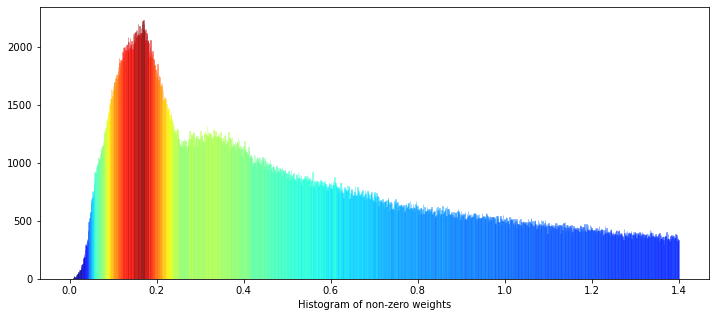

In [20]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['weight'], 
             bins=1400, 
             kde_kws={"clip":(0.001,1.4)}, 
             hist_kws={"range":(0.001,1.4)},
             color='darkcyan', 
             axlabel="Histogram of non-zero weights",
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.show();

There appear to be two peaks, one situated at `weight` $\approx$ 0.17, and a lower, broader peak at `weight` $\approx$ 0.34. (Could this be indicative of two underlying distributions that we see here, superimposed on each other?)

## <center style="background-color:Gainsboro; width:40%;">The features</center><a class="anchor" id="features"></a>
> "*This dataset contains an anonymized set of features, `feature_{0...129}`, representing real stock market data.*"

### feature_0
First of all, `feature_0` seems to be a little unusual, as it is composed solely of the integers `+1` or `-1`:

In [21]:
train_data['feature_0'].value_counts()

 1    1207005
-1    1183486
Name: feature_0, dtype: int64

Also, `feature_0` is the *only* feature in the `features.csv` file that has no `True` tags.

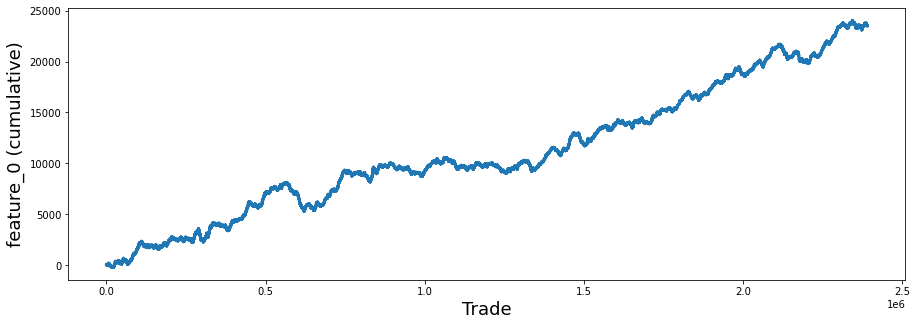

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_0 = pd.Series(train_data['feature_0']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("feature_0 (cumulative)", fontsize=18);
feature_0.plot(lw=3);

Any suggestions are welcome, and can be posted on the thread ["What is "feature_0" ?"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/199462). 

See also this very interesting notebook ["*Feature 0, beyond feature 0*"](https://www.kaggle.com/nanomathias/feature-0-beyond-feature-0) written by [NanoMathias](https://www.kaggle.com/nanomathias), where he performs a [uniform manifold approximation and projection (UMAP)](https://arxiv.org/abs/1802.03426) and shows that `feature_0`  effectively classifies the two distributions.

### feature_{1...129}
There seem to be four general 'types' of features, here is a plot of an example of one of each:

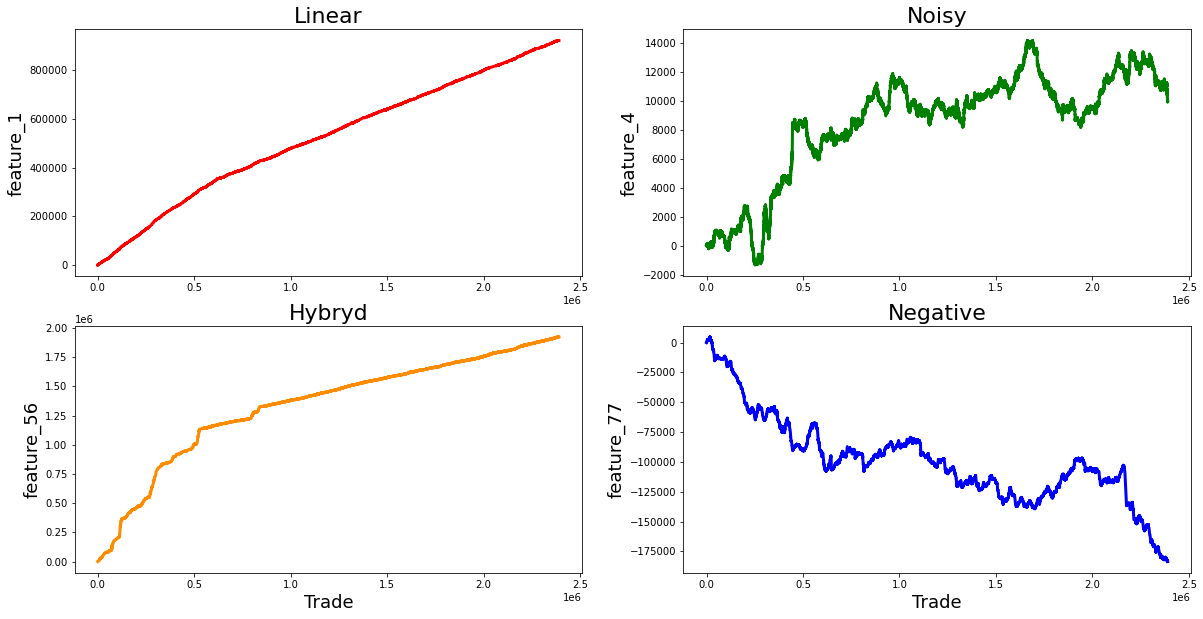

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,10))

ax1.plot((pd.Series(train_data['feature_1']).cumsum()), lw=3, color='red')
ax1.set_title ("Linear", fontsize=22);
ax1.set_ylabel ("feature_1", fontsize=18);

ax2.plot((pd.Series(train_data['feature_4']).cumsum()), lw=3, color='green')
ax2.set_title ("Noisy", fontsize=22);
ax2.set_ylabel ("feature_4", fontsize=18);

ax3.plot((pd.Series(train_data['feature_56']).cumsum()), lw=3, color='darkorange')
ax3.set_title ("Hybryd", fontsize=22);
ax3.set_xlabel ("Trade", fontsize=18)
ax3.set_ylabel ("feature_56", fontsize=18);

ax4.plot((pd.Series(train_data['feature_77']).cumsum()), lw=3, color='blue')
ax4.set_title ("Negative", fontsize=22)
ax4.set_xlabel ("Trade", fontsize=18)
ax4.set_ylabel ("feature_77", fontsize=18);

### 'Linear' features
Features 1, 7, 9, 11, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 41, 46, 47, 48, 49, 50, 51, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95 (strong change in gradient), 96, 97, 98, 99, 100, 101, 102 (strong change in gradient), 103, 104, 105, 106, 107 (strong change in gradient), 108, 110, 111, 113, 114, 115, 116, 117, 118, 119 (strong change in gradient), 120, 122, and 124.

### 'Noisy' features
Features 3, 4, 5, 6, 8, 12, 37, 38, 72, 74, 78, 80, 83.

### 'Hybrid' features
That start off noisy, but then go linear; 55, 56, 57, 58, 59.

### 'Negative' features
Features 73, 75, 76, 77 (noisy), 79, 81(noisy), 82.

The other features are somewhere in between, or a combination of, what we have seen above.

## <center style="background-color:Gainsboro; width:40%;">The features.csv file</center><a class="anchor" id="features_file"></a>
We are also provided with a `features.csv` file which contains "*metadata pertaining to the anonymized features*". Let us take a quick look at it, where `1` is `True` and `0` is `False`. The file has 29 "tags" associated with each feature. (I must say that at the moment I have no idea what this file represents, or how to use it).

In [24]:
feature_tags = pd.read_csv("../input/jane-street-market-prediction/features.csv" ,index_col=0)
# convert to binary
feature_tags = feature_tags*1
#feature_tags.style.background_gradient(cmap='Oranges')
# plot a transposed dataframe
feature_tags.T.style.background_gradient(cmap='Oranges')

Let us sum the number of tags for each feature:

In [25]:
tag_sum = pd.DataFrame(feature_tags.T.sum(axis=0),columns=['Number of tags'])
tag_sum.T

feature         feature_0  feature_1  feature_2  feature_3  feature_4  \
Number of tags          0          2          3          2          3   

feature         feature_5  feature_6  feature_7  feature_8  feature_9  \
Number of tags          2          3          3          4          3   

feature         feature_10  feature_11  feature_12  feature_13  feature_14  \
Number of tags           4           3           4           3           4   

feature         feature_15  feature_16  feature_17  feature_18  feature_19  \
Number of tags           3           4           3           4           3   

feature         feature_20  feature_21  feature_22  feature_23  feature_24  \
Number of tags           4           3           4           3           4   

feature         feature_25  feature_26  feature_27  feature_28  feature_29  \
Number of tags           3           4           3           4           3   

feature         feature_30  feature_31  feature_32  feature_33  feature_34  \
Number of tags           4           3           4           3           4   

feature         feature_35  feature_36  feature_37  feature_38  feature_39  \
Number of tags           3           4           2           3           2   

feature         feature_40  feature_41  feature_42  feature_43  feature_44  \
Number of tags           3           1           1           1           2   

feature         feature_45  feature_46  feature_47  feature_48  feature_49  \
Number of tags           2           2           1           1           2   

feature         feature_50  feature_51  feature_52  feature_53  feature_54  \
Number of tags           2           1           1           2           3   

feature         feature_55  feature_56  feature_57  feature_58  feature_59  \
Number of tags           2           2           2           2           2   

feature         feature_60  feature_61  feature_62  feature_63  feature_64  \
Number of tags           2           2           2           2           1   

feature         feature_65  feature_66  feature_67  feature_68  feature_69  \
Number of tags           2           2           2           2           1   

feature         feature_70  feature_71  feature_72  feature_73  feature_74  \
Number of tags           2           2           4           4           4   

feature         feature_75  feature_76  feature_77  feature_78  feature_79  \
Number of tags           4           4           4           4           4   

feature         feature_80  feature_81  feature_82  feature_83  feature_84  \
Number of tags           4           4           4           4           4   

feature         feature_85  feature_86  feature_87  feature_88  feature_89  \
Number of tags           4           4           4           4           4   

feature         feature_90  feature_91  feature_92  feature_93  feature_94  \
Number of tags           4           4           4           4           4   

feature         feature_95  feature_96  feature_97  feature_98  feature_99  \
Number of tags           4           4           4           4           4   

feature         feature_100  feature_101  feature_102  feature_103  \
Number of tags            4            4            4            4   

feature         feature_104  feature_105  feature_106  feature_107  \
Number of tags            4            4            4            4   

feature         feature_108  feature_109  feature_110  feature_111  \
Number of tags            4            4            4            4   

feature         feature_112  feature_113  feature_114  feature_115  \
Number of tags            4            4            4            4   

feature         feature_116  feature_117  feature_118  feature_119  \
Number of tags            4            4            4            4   

feature         feature_120  feature_121  feature_122  feature_123  \
Number of tags            2            3            2            3   

feature         feature_124  featu

We can see that all of the features have at least one tag, and some as many a four. All except, that is, for `feature_0`, which has no tags at all.

## <center style="background-color:Gainsboro; width:40%;">Action</center><a class="anchor" id="action"></a>
The target of this competition is the `action`: 1 to make the trade and 0 to pass on it. In view of this let us add a new 'binary' column to our test dataset called `action` such that if `resp` is positive then `action=1` else `action=0`

In [26]:
train_data['action'] = ((train_data['resp'])>0)*1

This is only a simple example for this EDA. I suspect that the actual formula that one uses to calculate the `action` will be critical in obtaining a good final score.

## <center style="background-color:Gainsboro; width:80%;">Now let us take a look at the first day ("day 0")</center><a class="anchor" id="day_0"></a>
To do this we shall make a new dataframe called `day_0`

In [27]:
day_0 = train_data.loc[train_data['date'] == 0]

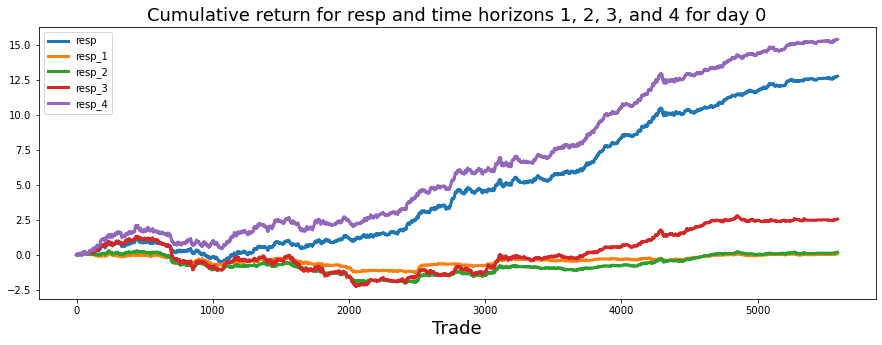

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(day_0['resp']).cumsum()
resp_1= pd.Series(day_0['resp_1']).cumsum()
resp_2= pd.Series(day_0['resp_2']).cumsum()
resp_3= pd.Series(day_0['resp_3']).cumsum()
resp_4= pd.Series(day_0['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return for resp and time horizons 1, 2, 3, and 4 for day 0", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

### <center style="background-color:Gainsboro; width:60%;">Descriptive statistics of the `train.csv` file for day 0</center>
Some simple [descriptive statistics](https://en.wikipedia.org/wiki/Descriptive_statistics) of the day 0 data:

In [29]:
day_0.describe().style.background_gradient(cmap=colorMap)

## <center style="background-color:Gainsboro; width:60%;">Is there any missing data?</center><a class="anchor" id="missing"></a>

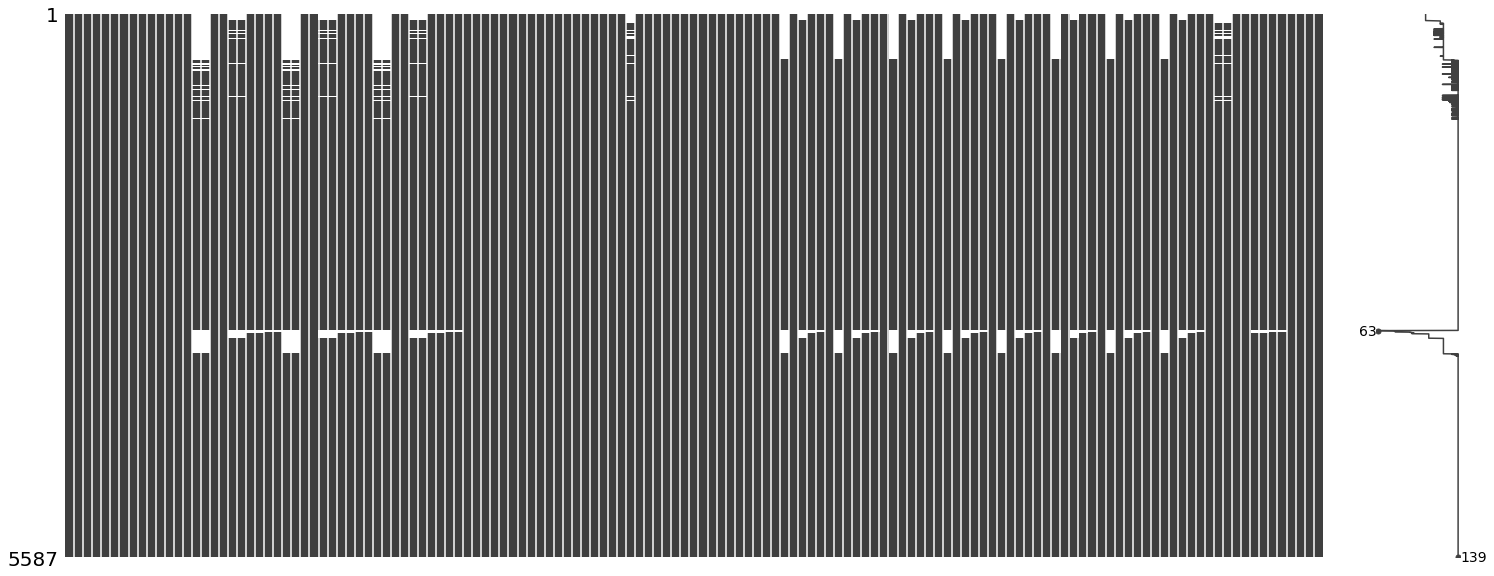

In [30]:
msno.matrix(day_0);

Graphically we can see that indeed there are chunks of missing data (in white) in some of the columns. 

Let us look at the number of missing data for the whole `train.csv` file:

In [31]:
missing_data = pd.DataFrame(train_data.isna().sum().sort_values(ascending=False),columns=['Total missing'])
missing_data.T

feature_17  feature_18  feature_28  feature_27  feature_7  \
Total missing      395535      395535      395535      395535     393135   

               feature_8  feature_102  feature_72  feature_108  feature_90  \
Total missing     393135       351426      351426       351426      351426   

               feature_96  feature_114  feature_78  feature_84  feature_31  \
Total missing      351426       351426      351426      351426       81444   

               feature_22  feature_21  feature_32  feature_12  feature_11  \
Total missing       81444       81444       81444       80015       80015   

               feature_120  feature_121  feature_55  feature_98  feature_110  \
Total missing        69854        69854       68409       64088        64088   

               feature_116  feature_104  feature_86  feature_92  feature_74  \
Total missing        64088        64088       64088       64088       64088   

               feature_80  feature_124  feature_125  feature_13  feature_75  \
Total missing       64088        16083        16083       15353       15353   

               feature_14  feature_23  feature_24  feature_34  feature_33  \
Total missing       15353       15353       15353       15353       15353   

               feature_87  feature_81  feature_111  feature_99  feature_117  \
Total missing       15353       15353        15353       15353        15353   

               feature_105  feature_93  feature_126  feature_127  feature_82  \
Total missing        15353       15353         8853         8853        6683   

               feature_25  feature_118  feature_35  feature_26  feature_100  \
Total missing        6683         6683        6683        6683         6683   

               feature_36  feature_88  feature_112  feature_94  feature_106  \
Total missing        6683        6683         6683        6683         6683   

               feature_16  feature_15  feature_76  feature_128  feature_129  \
Total missing        6683        6683        6683         1921         1921   

               feature_85  feature_115  feature_91  feature_19  feature_20  \
Total missing         788          788         788         788         788   

               feature_9  feature_109  feature_103  feature_10  feature_97  \
Total missing        788          788          788         788         788   

               feature_29  feature_79  feature_73  feature_30  feature_56  \
Total missing         788         788         788         788         719   

               feature_45  feature_3  feature_4  feature_44  feature_123  \
Total missing         448        448        448         448          223   

               feature_122  feature_59  feature_58  resp  weight  resp_1  \
Total missing          223          48           1     0       0       0   

               resp_2  feature_6  feature_5  feature_2  resp_3  feature_1  \
Total missing       0          0          0          0       0          0   

               resp_4  feature_0  action  feature_62  feature_37  feature_71  \
Total missing       0          0       0           0           0           0   

               feature_64  feature_65  feature_66  feature_67  feature_68  \
Total missing           0           0           0           0           0   

               feature_69  feature_70  feature_77  feature_38  feature_83  \
Total missing           0           0           0           0           0   

               feature_89  feature_95  feature_101  feature_107  feature_113  \
Total missing           0           0            0            0            0   

               feature_119  feature_63  ts_id  feature_61  feature_60  \
Total missing            0           0      0           0           0   

               feature_39  feature_40  feature_41  feature_42  feature_43  \
Total missing           0           0           0           0           0   

               feature_46  feature_47  feature_48  feature_49  feature_50  \
Total missing        

We can see that features 7 and 8 both have exactly the same number of missing values (393135). 
17 and 18, and 27 and 28 all have 395535 missing values (which is around 16.5%). 

Next we have features 72, 78, 84, 90, 96, 102, 108, 114 all with 351426 missing values each ($\approx$ 15%). It is curious to note that these columns are separated by five columns in between each of them (perhaps the five days in a week?)

Features 21, 22, 31, 32 have 81444 missing values (3.4%), closely followed by features 11 and 12.

There are more features with even less missing values. I think the interesting thing is not so much the quantity of missing values in so much as it may tell us which features represent similar measures/metrics.

Is day 0 special, or does every day have missing data?

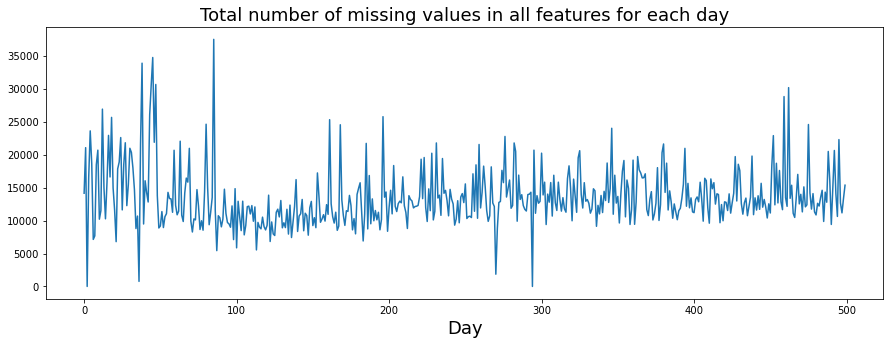

In [32]:
missing_features = train_data.iloc[:,7:137].isnull().groupby(train_data['date']).sum()
# now make a plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(missing_features.sum(axis=1))
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of missing values in all features for each day", fontsize=18)
plt.show()

Indeed we can see that there is missing data every day, with no discernible pattern (weekly, monthly, *etc*).

## <center style="background-color:Gainsboro; width:20%;">DABL plots</center><a class="anchor" id="DABL"></a>

Let us run **day 0** through the *data analysis baseline library* [dabl](https://github.com/amueller/dabl). First using the `action` as the target:

Target looks like classification
Showing only top 10 of 135 continuous features
Linear Discriminant Analysis training set score: 0.875


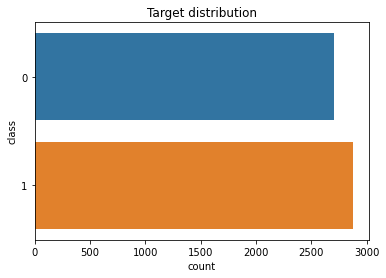

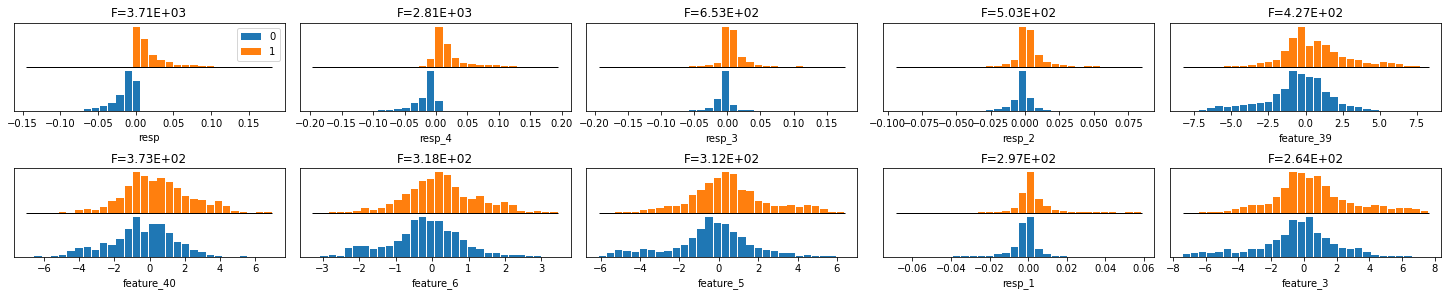

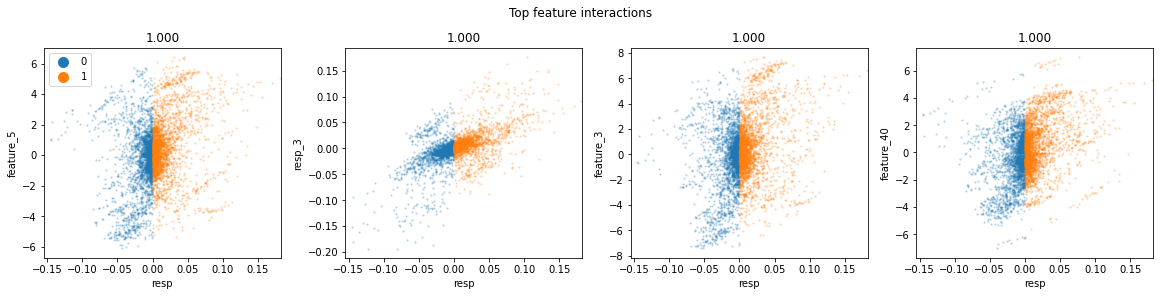

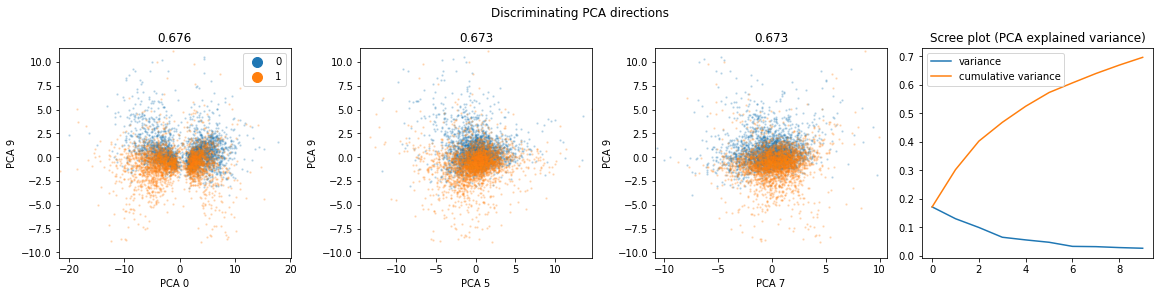

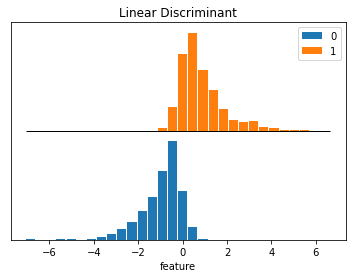

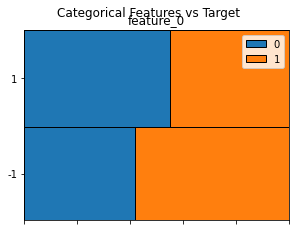

In [41]:
dabl.plot(day_0, target_col="action")

We can see that the classes 0 and 1 for `action` are reasonably well balanced.

Now we shall use `resp` as the target:

Target looks like regression
Showing only top 10 of 134 continuous features


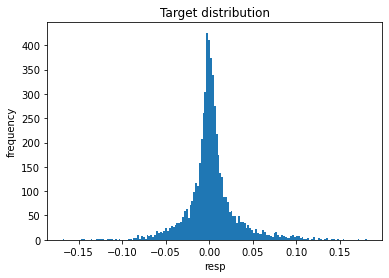

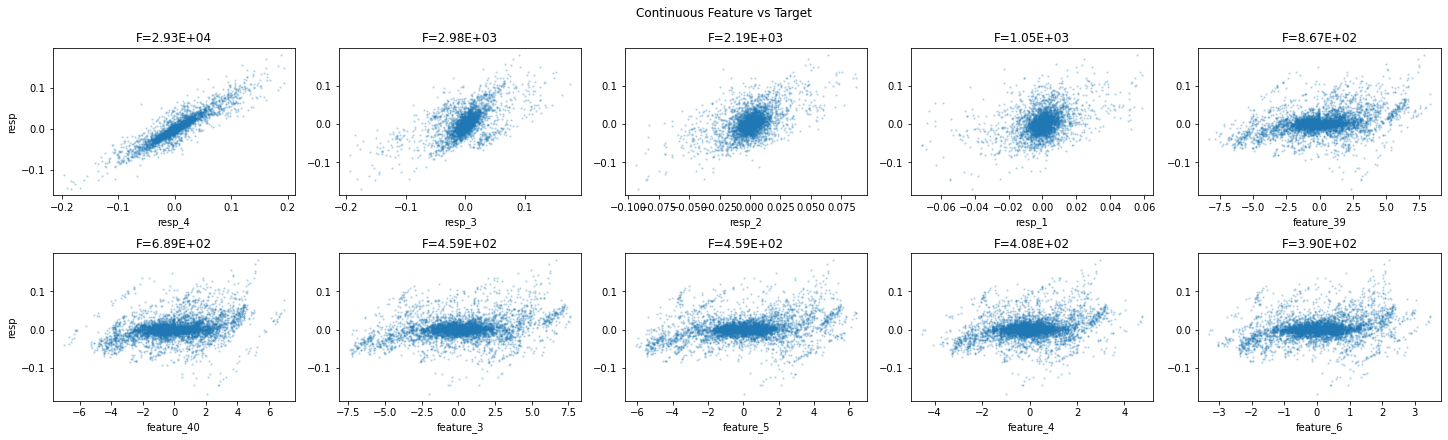

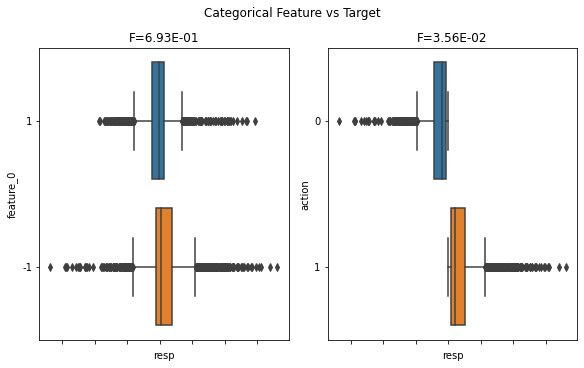

In [33]:
dabl.plot(day_0, target_col="resp")

### Plot the return (`resp`) with respect to time (`ts_id`) for day 0

In [42]:
fig_1 = px.scatter(day_0, x=day_0['ts_id'], y=day_0['resp'], 
                   trendline="ols", marginal_y="violin",
                   title=("Scatter plot of resp with respect to ts_id for day 0"))
fig_1.show()

# <center style="background-color:Gainsboro; width:100%;">Very quick Permutation Importance using the Random Forest</center><a class="anchor" id="permutation"></a>
We shall now perform a simple [permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) calculation, a basic way of seeing which features may be important. We shall perform a regression, with `resp` as the target.

In [35]:
X_train = day_0.loc[:, day_0.columns.str.contains('feature')]
X_train = X_train.fillna(X_train.mean())
# our target is the action
y_train = day_0['resp']

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_features='auto')
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [36]:
import eli5
from eli5.sklearn import PermutationImportance
perm_import = PermutationImportance(regressor, random_state=1).fit(X_train, y_train)
# visualize the results
eli5.show_weights(perm_import, top=15, feature_names = X_train.columns.tolist())

We can see that for the first day (**day 0**) the top 5 most important features appear to be 39, 43, 37, 5 and 42.

Note:

> Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. (Source: [scikit-learn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)).

## <center style="background-color:Gainsboro; width:80%;">Is there any correlation between day 0 and day 1?</center><a class="anchor" id="Pearson"></a>
Are the days independent? For the moment let us take a look at day(0) and day(1) using a [Pearson pairwise correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) matrix (this is a **big** matrix!). We shall use a [diverging colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) where red indicates positive linear correlation, and blue indicates linear anti-correlation:

In [37]:
day_1 = train_data.loc[train_data['date'] == 1]
day_0_and_1 = pd.concat([day_0, day_1])
day_0_and_1.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

We can see that between days 0 and 1 there is a 0.95 correlation between `resp_4` and `resp` (as we saw above), 0.72 between `resp_3` and `resp`, 0.53 between `resp_2` and `resp`, and 0.39 between `resp_1` and `resp`. 

We can see a correlation of 0.64 between our simple definition of `action` and the value of `resp`.

Navigating around there do appear to be some rather curious regions, for example between features 120 through to 129:

In [38]:
subset = day_0_and_1[["feature_120","feature_121","feature_122","feature_123","feature_124","feature_125","feature_126","feature_127","feature_128","feature_129"]]
subset.corr().style.background_gradient(cmap='coolwarm', low=1, high=0, axis=None).set_precision(2)

...not sure what this means at the moment!

# <center style="background-color:Gainsboro; width:40%;">The test data</center><a class="anchor" id="test_data"></a>
The wall time taken for a submission to return a score in this competition is around 3½ hours, so testing a script before submitting is (as always) *very* important. We are provided with some test data in the smaller (36 MB) file `example_test.csv`. This file contains over 15k rows, and covers 3 days of data. It consists of the 130 `features` as in the `train.csv`, as well as the `weight` for each trade. It is interesting to note that `example_test.csv` contains no `resp` data.

<a class="anchor" id="evaluation"></a>
# <center style="background-color:Gainsboro; width:40%;">Evaluation</center>
This competition is evaluated via a utility score $(u)$. For a detailed description of this score see the excellent notebook ["*Understanding the Utility Score Function*"](https://www.kaggle.com/renataghisloti/understanding-the-utility-score-function) written by [Renata Ghisloti Duarte de Souza](https://www.kaggle.com/renataghisloti).

### <center style="background-color:LightGreen; width:40%;">Thank you for your time!</center>